In [190]:
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
import scipy.optimize
from scipy.optimize import minimize
from scipy.special import jv
#from scipy.ndimage import gaussian_filter1d
import sys


import qgm
from qgm import image, parameter, filter, data, fitting, function
from qgm.image import pixel_shift
from qgm import search_atoms
from qgm.deconvolution import deconvolution

cmap = image.generate_cmap(['#330000', 'r', 'w'])


In [191]:
date = '20220624'
dataNo = 1
scanNo = 1

In [192]:
path = r"./"+date
path_img = path + r"/data" + str('%03d' % dataNo) + "/raw"
path_scan = path + r"/scandir/Scan" + str('%03d' % scanNo) + '.txt'
path_param = path + r"/scandir/Parameters" + str('%03d' % scanNo) + '.txt'
scan_data = pd.read_csv(path_scan, delimiter='\t')

In [193]:
param_name ='A0144: LS final amplitude 1'
scan_param =scan_data[param_name]
unique_param = scan_param.unique()
sample1 = unique_param[2]
sample2 = unique_param[10]
sample3 = unique_param[16]
unit = '[V]'
flcount = scan_data['Total count1 @ ROI1 (arb. u.)']

In [194]:
share = Path(path_img)
if share.exists():
    trans_files = list(Path(path_img).glob('seq*_trans001.tiff'))
    flat_files = list(Path(path_img).glob('seq*_flat001.tiff'))
    update_files = list(Path(path_img).glob('seq*_update001.tiff'))
else:
    print('No images')

img_flat_ave =[]
img_trans_ave = []
img_trans_list = []
for N in range(len(trans_files)):
    img_flat_ave += [np.array(Image.open(flat_files[N]))]
    img_trans_ave += [np.array(Image.open(trans_files[N]))]
img_flat_ave = np.average(img_flat_ave,axis=0)
img_trans_ave =np.average(img_trans_ave,axis=0) -img_flat_ave
for N in range(len(trans_files)):
    img_trans_list += [np.array(Image.open(trans_files[N])) - img_flat_ave]

img_trans_sample1 = []
img_trans_sample2 = []
img_trans_sample3 = []
for N in range(len(trans_files)):
    if scan_param[N] == sample1:
        img_trans_sample1 += [np.array(Image.open(trans_files[N]))]
    elif scan_param[N] == sample2:
        img_trans_sample2 += [np.array(Image.open(trans_files[N]))]
    elif scan_param[N] == sample3:
        img_trans_sample3 += [np.array(Image.open(trans_files[N]))]
img_trans_sample1 = np.average(img_trans_sample1,axis=0) -img_flat_ave
img_trans_sample2 = np.average(img_trans_sample2,axis=0) -img_flat_ave
img_trans_sample3 = np.average(img_trans_sample3,axis=0) -img_flat_ave

Text(0.5, 1.0, '8.0[V]')

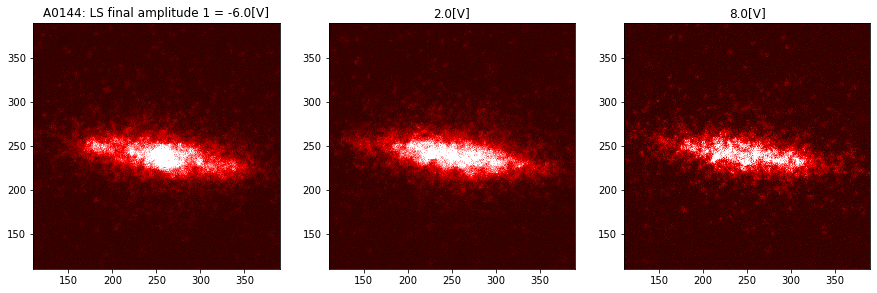

In [195]:
vmin = 0
vmax = 1500
xlim_1 = 110
xlim_2 = 390
ylim_1 = 110
ylim_2 = 390

fig =plt.figure(figsize=[15,10])
ax1 = fig.add_subplot(2,3,1)
mappable =ax1.pcolormesh(img_trans_sample1, cmap=cmap,vmin=vmin, vmax=vmax, shading='auto')
ax1.set_aspect('equal')
ax1.set_xlim(xlim_1,xlim_2)
ax1.set_ylim(ylim_1,ylim_2)
ax1.set_title(param_name+ " = %.01f"%(sample1)+unit)

ax2 = fig.add_subplot(2,3,2)
mappable =ax2.pcolormesh(img_trans_sample2, cmap=cmap, vmin=vmin, vmax=vmax, shading='auto')
ax2.set_aspect('equal')
ax2.set_xlim(xlim_1,xlim_2)
ax2.set_ylim(ylim_1,ylim_2)
ax2.set_title("%.01f"%(sample2)+unit)

ax3 = fig.add_subplot(2,3,3)
mappable =ax3.pcolormesh(img_trans_sample3, cmap=cmap, vmin=vmin, vmax=vmax, shading='auto')
ax3.set_aspect('equal')
ax3.set_xlim(xlim_1,xlim_2)
ax3.set_ylim(ylim_1,ylim_2)
ax3.set_title("%.01f"%(sample3)+unit)

In [196]:
cx = 252
cy = 240
wx = 12
wy = 12
shift_dx_list = [0, 33, -33, 66, -66]
shift_dy_list = [0, -5, 5, -10, 10]

subROI_parameters_list = []

def createSubROI(mainROI_cx, mainROI_cy, wx, wy, shift_dx=0, shift_dy=0):
    subROI_x0 = mainROI_cx + shift_dx - wx
    subROI_x1 = mainROI_cx + shift_dx + wx
    subROI_y0 = mainROI_cy + shift_dy - wy
    subROI_y1 = mainROI_cy + shift_dy + wy
    subROI_xmesh, subROI_ymesh = np.meshgrid(np.arange(subROI_x0,subROI_x1), np.arange(subROI_y0,subROI_y1))
    return subROI_xmesh, subROI_ymesh, subROI_x0, subROI_x1, subROI_y0, subROI_y1

for i in range(len(shift_dx_list)):
    subROI_parameters_temp = createSubROI(cx,cy, wx, wy, shift_dx_list[i], shift_dy_list[i])
    subROI_parameters_list.append(subROI_parameters_temp)

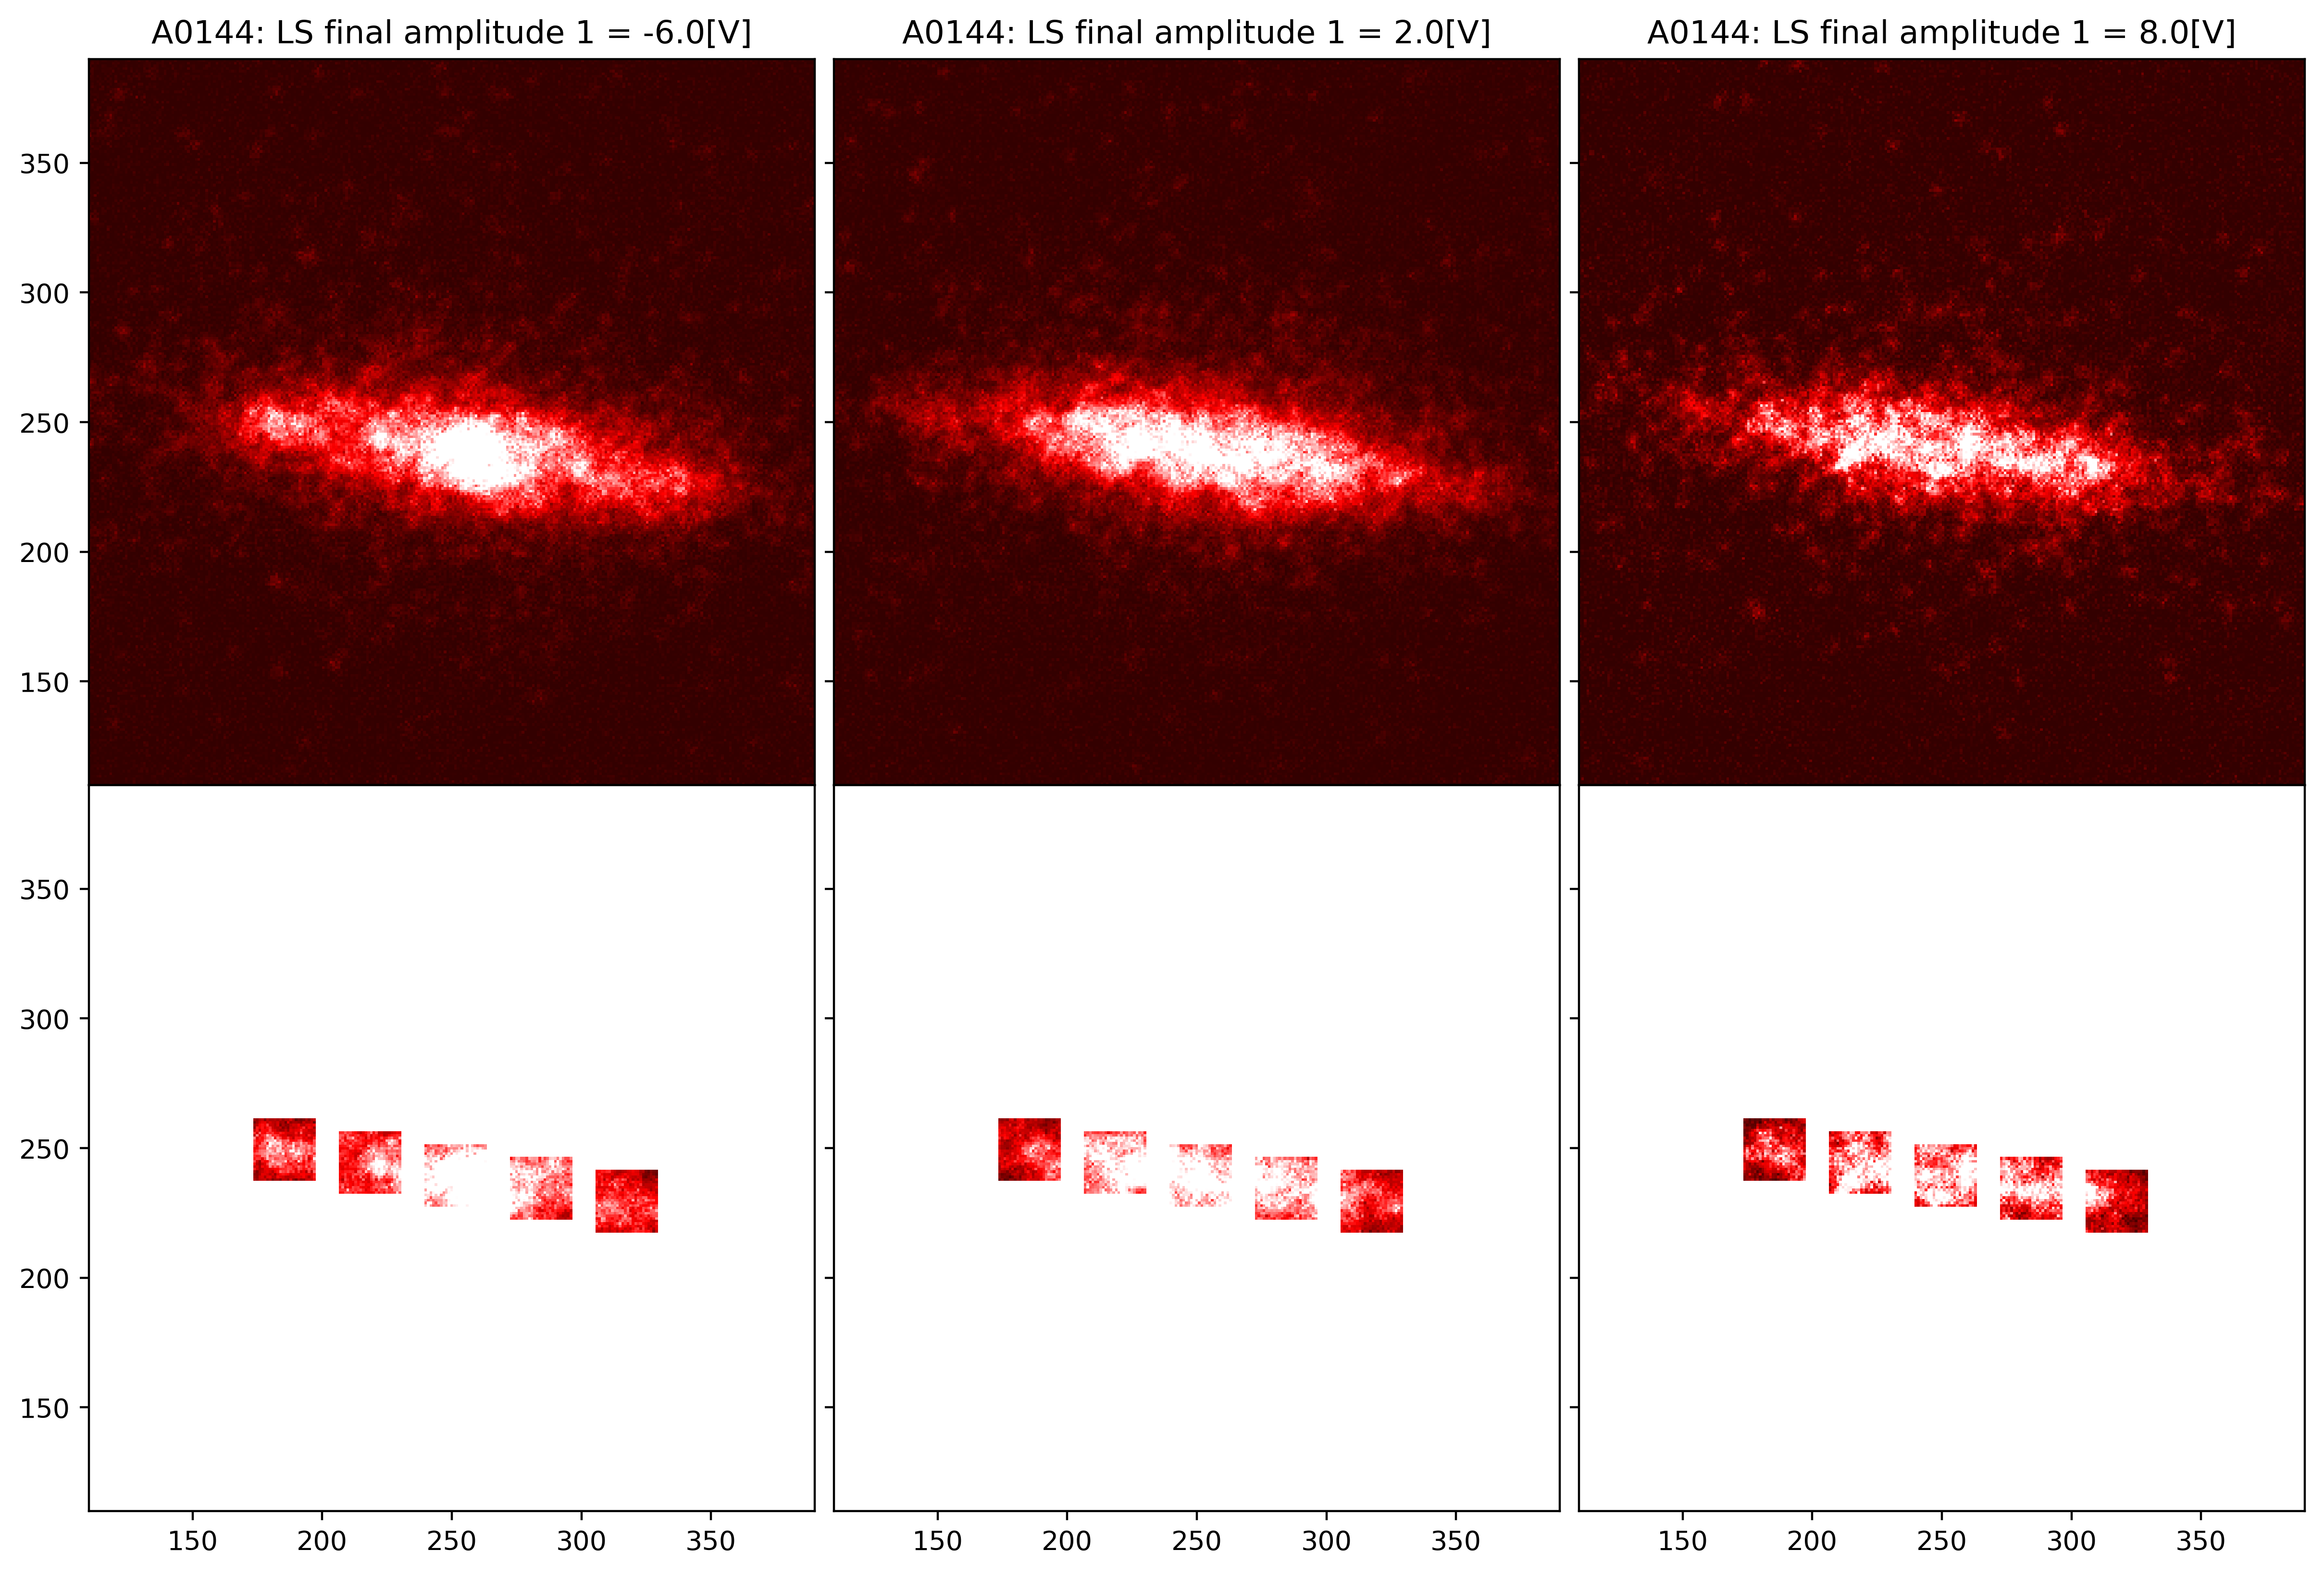

In [197]:
vmin = 0
vmax = 1500
# xlim_1 = 120
# xlim_2 = 360
# ylim_1 = 130
# ylim_2 = 370

sampleImages_list = [img_trans_sample1, img_trans_sample2, img_trans_sample3]
sample_list = [sample1, sample2, sample3]
fig, axs = plt.subplots(ncols=len(sampleImages_list), nrows=2, figsize=[15, 10], dpi=400, sharex=True, sharey=True)
axs = np.reshape(axs, [-1, ])
for i in range(len(sampleImages_list)*2):
    if i<len(sampleImages_list):
        axs[i].pcolormesh(sampleImages_list[i], vmin=vmin, vmax=vmax, cmap=cmap, shading='auto')
        axs[i].set_title(param_name+ " = %.01f"%(sample_list[i])+unit)
    else:
        for j in range(len(shift_dx_list)):
            axs[i].pcolormesh(subROI_parameters_list[j][0],subROI_parameters_list[j][1],sampleImages_list[i-len(sampleImages_list)][subROI_parameters_list[j][4]:subROI_parameters_list[j][5],subROI_parameters_list[j][2]:subROI_parameters_list[j][3]], vmin=vmin, vmax=vmax, cmap=cmap, shading='auto')
    axs[i].set_aspect('equal')
    axs[i].set_xlim(xlim_1,xlim_2)
    axs[i].set_ylim(ylim_1,ylim_2)
fig.subplots_adjust(hspace=0, wspace=0)
plt.show()

In [198]:
center_list = []
side1_list = []
side2_list = []
center_err_list = []
side1_err_list = []
side2_err_list = []
visibility_list = []
visibility_err_list = []  
for i in range(len(unique_param)):
    center_temp = []
    side1_temp = []
    side2_temp = []
    visibility_temp = []
    for j in range(len(trans_files)):
        if scan_param[j] == unique_param[i]:
            center_temp.append(np.sum(img_trans_list[j][subROI_parameters_list[0][4]:subROI_parameters_list[0][5],subROI_parameters_list[0][2]:subROI_parameters_list[0][3]])/np.sum(img_trans_list[j]))
            side1_temp.append(np.sum(list(map(lambda x: img_trans_list[j][subROI_parameters_list[x][4]:subROI_parameters_list[x][5],subROI_parameters_list[x][2]:subROI_parameters_list[x][3]], range(1,3,1))))/np.sum(img_trans_list[j]))
            side2_temp.append(np.sum(list(map(lambda x: img_trans_list[j][subROI_parameters_list[x][4]:subROI_parameters_list[x][5],subROI_parameters_list[x][2]:subROI_parameters_list[x][3]], range(3,5,1))))/np.sum(img_trans_list[j]))
            visibility_temp.append((center_temp[-1]-side1_temp[-1]+side2_temp[-1])/(center_temp[-1]+side1_temp[-1]+side2_temp[-1]))
    center_list.append(np.mean(center_temp))
    side1_list.append(np.mean(side1_temp))
    side2_list.append(np.mean(side2_temp))
    visibility_list.append(np.mean(visibility_temp))
    center_err_list.append(np.std(center_temp))
    side1_err_list.append(np.std(side1_temp))
    side2_err_list.append(np.std(side2_temp))
    visibility_err_list.append(np.std(visibility_temp))

In [199]:
import numpy as np
from scipy import constants
print(constants.h)
mrb = 87*1.66053873*10**(-27) #Single atom mass of 174Yb [kg]
print(1/constants.N_A*10**(-3))
dl=2/3*1064*10**(-9) #lattice constants [m]
FMdeviation = 10*1e3
controlVoltageToAM = 8 #[V] control voltage from NI-DAQ to WF1968 mod. in via buffer amp
modulationSignalVpp = 8 #[V] Amplitude of modulation singal
bufferAmpForAM = 1/8 # gain of buffer amp for modulatin sinal
FMdeviation = 10*1e3 #[Hz] FM deviation used in RF source
bufferAmpForFM = 1/4 # gain of buffer amp for RF source
dvmax = (unique_param*bufferAmpForAM+1)/2*modulationSignalVpp*bufferAmpForFM/2*FMdeviation #[Hz]
K0 = 2*np.pi*mrb*dl**2*dvmax/(constants.h)

K_list = np.linspace(np.min(K0),np.max(K0),100)
jv_list = jv(0, K_list)

6.62607015e-34
1.6605390671738466e-27


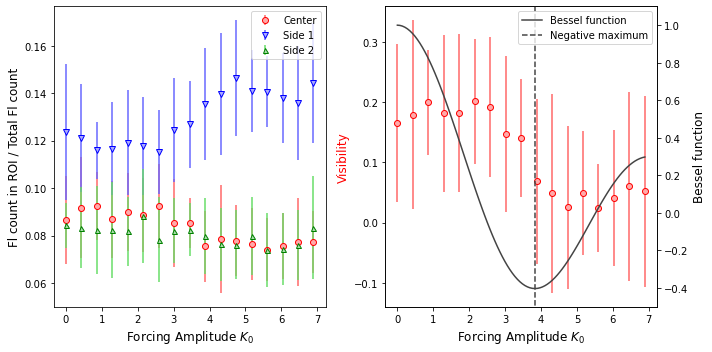

In [222]:
fig =plt.figure(figsize=[10,5])
ax1 = fig.add_subplot(1,2,1)
ax1.errorbar(K0,center_list,center_err_list,fmt = 'o', c='#ff6666', mec='r', mfc='#ffaaaa',label='Center')
ax1.errorbar(K0,side1_list,side1_err_list, fmt='v',c='#6666ff', mec='b', mfc='#aaaaff',label='Side 1')
ax1.errorbar(K0,side2_list,side2_err_list, fmt='^',c='#66dd66', mec='g', mfc='#aaddaa',markersize=5,label='Side 2')
ax1.set_xlabel(r'Forcing Amplitude $K_0$',fontsize=12)
ax1.set_ylabel('Fl count in ROI / Total Fl count',fontsize=12)
ax1.legend()

ax2 = fig.add_subplot(1,2,2)
ax2.errorbar(K0,visibility_list,visibility_err_list,fmt = 'o', c='#ff6666', mec='r', mfc='#ffaaaa',label='Visibility')
ax2.set_ylabel('Visibility', color ='r', fontsize=12)
ax2.set_xlabel(r'Forcing Amplitude $K_0$',fontsize=12)

ax3=ax2.twinx()
ax3.plot(K_list, jv_list, c='#444444', zorder=1, label='Bessel function')
ax3.vlines(x=3.83,ymin=-1,ymax=2,linestyles='--',color='#444444', label='Negative maximum')
ax3.set_ylabel('Bessel function', color ='black', fontsize=12)
ax3.set_ylim(-0.5, 1.1)
ax3.legend()
plt.tight_layout()